In [1]:
import sys
print(sys.executable)
print(sys.version)

/Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/.venv/bin/python
3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]


In [2]:
import pandas as pd
pd.__version__

import os 
os.getcwd()

'/Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/notebooks'

In [3]:
import sqlite3, os, pandas as pd

print("CWD:", os.getcwd())

REPO_ROOT = os.path.dirname(os.getcwd()) # assuming the notebook is in the root of the repo # goes up from notebooks/ to the repo root
DB_PATH = os.path.join(REPO_ROOT, "data", "training.sqlite")

print("DB_PATH:", DB_PATH)
print("DB exists?", os.path.exists(DB_PATH))

conn = sqlite3.connect(DB_PATH)
weekly = pd.read_sql_query("SELECT * FROM weekly_e1rm ORDER BY week_start, exercise", conn)
conn.close()

weekly


CWD: /Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/notebooks
DB_PATH: /Users/somtonwandu/myrepo/Strength_training_analytics/Strength-progression-forecast/data/training.sqlite
DB exists? True


,week_start,exercise,e1rm
0,2026-02-02,Bench Press,116.666667
1,2026-02-02,Deadlift,204.166667
2,2026-02-02,Squat,160.416667
3,2026-02-09,Bench Press,115.500000
4,2026-02-09,Deadlift,203.500000
5,2026-02-09,Squat,159.500000


In [4]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import matplotlib.pyplot as plt

# Make a tidy datetime column for plotting
weekly_plot = weekly.copy()
weekly_plot["week_start"] = pd.to_datetime(weekly_plot["week_start"])

# Pivot so each lift becomes a column
wide = weekly_plot.pivot(index="week_start", columns="exercise", values="e1rm").sort_index()
wide


exercise,Bench Press,Deadlift,Squat
week_start,,,
2026-02-02,116.666667,204.166667,160.416667
2026-02-09,115.500000,203.500000,159.500000


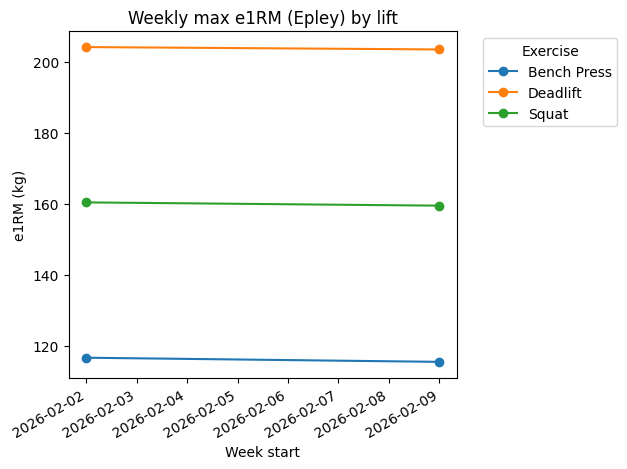

In [6]:
ax = wide.plot(marker="o")
ax.set_title("Weekly max e1RM (Epley) by lift")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")

# Position the legend outside the plot area
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

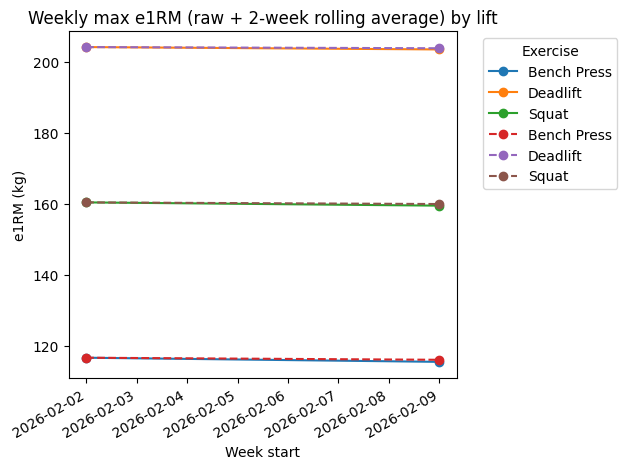

In [7]:
# Add a 2-week rolling average to smooth out the lines
wide_roll2 = wide.rolling(window=2, min_periods=1).mean()

ax = wide.plot(marker="o")
wide_roll2.plot(ax=ax, marker="o", linestyle="--")
ax.set_title("Weekly max e1RM (raw + 2-week rolling average) by lift")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
%pip install numpy
import numpy as np



Note: you may need to restart the kernel to use updated packages.


In [9]:
# Make a copy so we do not mutate the plotting table
trend_df = weekly_plot.copy()

# Convert week_start to a numeric index (weeks since first observation)
trend_df["week_index"] = (trend_df["week_start"] - trend_df["week_start"].min()).dt.days / 7

trend_df

,week_start,exercise,e1rm,week_index
0,2026-02-02,Bench Press,116.666667,0.0
1,2026-02-02,Deadlift,204.166667,0.0
2,2026-02-02,Squat,160.416667,0.0
3,2026-02-09,Bench Press,115.500000,1.0
4,2026-02-09,Deadlift,203.500000,1.0
5,2026-02-09,Squat,159.500000,1.0


In [10]:
# Fit a simple linear trend per lift

from numpy.polynomial.polynomial import polyfit

trend_results = {}

for exercise in trend_df["exercise"].unique():
    sub = trend_df[trend_df["exercise"] == exercise]
    
    x = sub["week_index"].values
    y = sub["e1rm"].values
    
    # Linear fit: y = a + b*x
    a, b = polyfit(x, y, deg=1)
    
    trend_results[exercise] = {"intercept": a, "slope_per_week": b}

trend_results

{'Bench Press': {'intercept': np.float64(116.66666666666663),
  'slope_per_week': np.float64(-1.166666666666643)},
 'Deadlift': {'intercept': np.float64(204.16666666666657),
  'slope_per_week': np.float64(-0.6666666666666572)},
 'Squat': {'intercept': np.float64(160.41666666666666),
  'slope_per_week': np.float64(-0.9166666666666856)}}

/var/folders/1n/nt517y8n3t91v8pb1n5b6dxw0000gn/T/ipykernel_57285/3653982690.py:8: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")


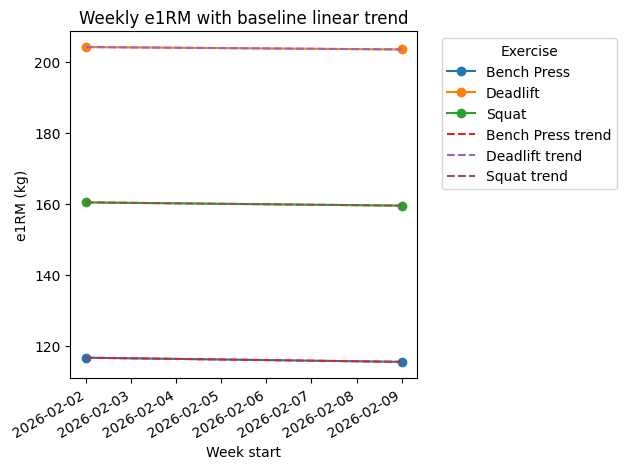

In [11]:
# Visualize baseline trendlines

ax = wide.plot(marker="o")

for exercise, params in trend_results.items():
    x = np.arange(len(wide))
    y = params["intercept"] + params["slope_per_week"] * x
    ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")

ax.set_title("Weekly e1RM with baseline linear trend")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")

# Position the legend outside the plot area
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
# Add uncertainty bands (e.g., +/- 5 kg) around the trendlines

residuals = [] # to store residuals for each exercise

for exercise, params in trend_results.items(): # loop through each exercise and its trend parameters
    sub = trend_df[trend_df["exercise"] == exercise] # filter the data for the current exercise
    
    y_hat = params["intercept"] + params["slope_per_week"] * sub["week_index"].values # calculate the predicted values from the trendline
    res = sub["e1rm"].values - y_hat # calculate the residuals (actual - predicted)
    
    residuals.append( # store the residuals in a DataFrame for later analysis
        pd.DataFrame({
            "exercise": exercise,
            "week_start": sub["week_start"],
            "residual": res
        })
    )
    
residuals_df = pd.concat(residuals) # combine the residuals from all exercises into a single DataFrame
residuals_df

,exercise,week_start,residual
0,Bench Press,2026-02-02,4.263256e-14
3,Bench Press,2026-02-09,2.842171e-14
1,Deadlift,2026-02-02,1.136868e-13
4,Deadlift,2026-02-09,1.136868e-13
2,Squat,2026-02-02,2.842171e-14
5,Squat,2026-02-09,2.842171e-14


In [13]:
# Estimate uncertainty as the standard deviation of the residuals for each exercise

uncertainty = (
    residuals_df.groupby("exercise")["residual"]
    .std()
    .rename("sigma")
)
uncertainty

exercise
Bench Press    1.004859e-14
Deadlift       0.000000e+00
Squat          0.000000e+00
Name: sigma, dtype: float64

/var/folders/1n/nt517y8n3t91v8pb1n5b6dxw0000gn/T/ipykernel_57285/2344553941.py:11: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")


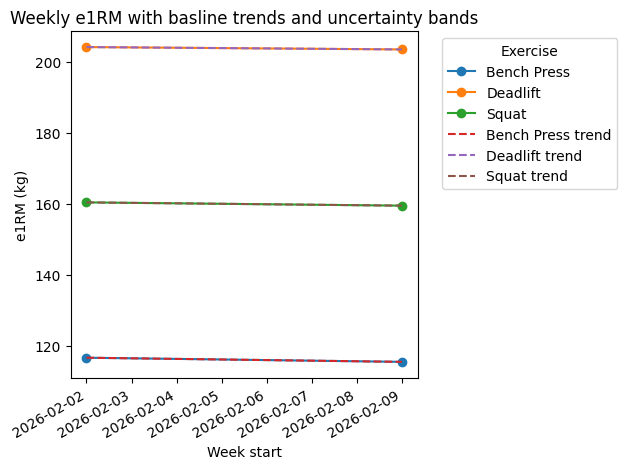

In [14]:
# Plot trend + +/- sigma bands

ax = wide.plot(marker="o")

for exercise, params in trend_results.items():
    sigma = uncertainty.loc[exercise] # get the standard deviation of residuals for the current exercise
    
    x = np.arange(len(wide))
    y = params["intercept"] + params["slope_per_week"] * x
    
    ax.plot(wide.index, y, linestyle="--", label=f"{exercise} trend")
    ax.fill_between(wide.index, y - sigma, y + sigma, alpha=0.2) # add a shaded area representing the uncertainty around the trendline

ax.set_title("Weekly e1RM with basline trends and uncertainty bands")
ax.set_xlabel("Week start")
ax.set_ylabel("e1RM (kg)")

# Position the legend outside the plot area
ax.legend(title="Exercise", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Phase 5 - Diminishing Returns + Scenario Forecasting

### Modeling Philosophy

Rules
1. Strength gains slow over time
    * Diminishing retruns are non-negotiable
2. Adherence affects the rate and not the direction
    * Missing sessions reduces slope and not max potential
3. Forecasts will widen over time
    * Uncertainty grows and never shrinks
4. We will be forecasting weekly e1RM and not the daily noise

Model
A logarithmic adaptation function because it cleanly captures the reality of strength training: big early gains that gradually taper off, without complex math.

With this in mind, we will use a logarithmic decay on weekly gains.

Conceptually:
    Expected e1RMₜ₊₁ = e1RMₜ + Δ₀ · log(1 + kₜ)^-1
    
Where:
* kₜ = training stimulus/dose in week t (e.g., volume × intensity)
* Δ₀ = max weekly gain potential when fresh (e.g., 2.5 kg for a squat)

Why it fits your criteria:
* ✅ Interpretable: Δ₀ = "best possible weekly gain when new to the program"
* ✅ Tunable: Adjust Δ₀ per lifter/exercise; kₜ scales with effort
* ✅ Explainable: "You gain fastest when starting out. Each extra week of hard training still helps—but less than the week before. Like learning a language: easy at first, harder to level up later."

Why not logistic? Logistic curves need extra parameters (e.g., asymptote, inflection point) that aren't reliably estimable from typical 8–12 week training blocks. Log form gives 80% of the insight with 20% of the complexity—ideal for practical forecasting.

## Define Baseline weekly gain (Δ₀)

We do not estimate this from 2 weeks of data, instead we will anchor it to evidence and my training status.

For intermediate lifters:

* Bench: ~0.25-0.5 kg/week e1RM early
* Squat: ~0.5-0.75 kg/week 
* Deadlift: ~0.75-1.0 kg/week

Although optimistic, these value represent realistic early-phase figures. 
We will encode them explicitly so the assumptions are transparent.


## Define adherence scenarios
Adherence modifies effective weekly gain, not the curve shape

| Scenario | Multiplier | Interpretation |
|:---------|:----------:|:---------------|
| 100%     | 1.0        | Never miss key sessions |
| 75%      | 0.7        | Occasional misses |
| 50%      | 0.45       | Inconsistent training |

In [15]:
# Define Forecast Horizon

weeks_ahead = 44 # ~Feb 2026 -> Dec 2026

weeks = np.arange(weeks_ahead) # create an array of week indices for the forecast horizon (0 to 43 weeks ahead)

weeks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [16]:
# Extract last osbserved e1RM as a starting point for the forecast (week_index = 0 for the forecast)

weekly_clean = weekly.copy()
weekly_clean["week_start"] = pd.to_datetime(weekly_clean["week_start"])
weekly_clean["exercise"] = weekly_clean["exercise"].astype(str).str.strip() # ensure exercise names are lowercase for consistency

last_obs = (
    weekly_clean.sort_values("week_start")
    .groupby("exercise", as_index=True) # group by exercise to get the last observation for each lift
    .tail(1) # get the last observation
    .set_index("exercise")["e1rm"] # set the index to exercise name
)

print(last_obs)
print("Index:", last_obs.index.tolist())

exercise
Bench Press    115.5
Deadlift       203.5
Squat          159.5
Name: e1rm, dtype: float64
Index: ['Bench Press', 'Deadlift', 'Squat']


In [17]:
last_obs.index.to_list()

['Bench Press', 'Deadlift', 'Squat']

In [18]:
# Define baseline weekly gains (explicit assumptions)

baseline_gains = {
    "Squat": 0.6, # kg per week
    "Bench Press": 0.4,
    "Deadlift": 0.9
}

print("baseline_gains keys:", list(baseline_gains.keys()))

baseline_gains keys: ['Squat', 'Bench Press', 'Deadlift']


In [19]:
# Define diminishing returns function

def diminishing_gain(delta0, week, k=12): # k is the diminishing returns parameter
    """

    delta0: intial weekly gain (kg)
    week: weeks since start of forecast
    k: controls how quickly gains diminish (higher k = slower diminishing)
    """
    return delta0 / np.log1p(week + k) # use log1p to avoid log(0) and control the shape of diminishing returns

In [20]:
print(type(last_obs))
print(last_obs)
print("last_obs.index:", last_obs.index)

<class 'pandas.Series'>
exercise
Bench Press    115.5
Deadlift       203.5
Squat          159.5
Name: e1rm, dtype: float64
last_obs.index: Index(['Bench Press', 'Deadlift', 'Squat'], dtype='str', name='exercise')


In [21]:
# Generate scenario projections

scenarios = {
    "100%": 1.0, # 100% adherence to weekly program and no misses
    "75%": 0.7, # 75% or occasional adherence (e.g., due to missed sessions, fatigue, etc.)
    "50%": 0.45 # inconsistent adherence (e.g., due to frequent missed sessions, fatigue, etc.)
}

projections = []

for exercise, e0 in last_obs.items(): # Loop through each exercise to generate projections
    e0 = float(e0) # ensure e0 is a float for calculations
    for scenario, mult in scenarios.items(): # Loop through each scenario multiplier
        values = [e0] # start with the last observed e1RM as the first value in the projection
        
        for w in weeks[1:]: # Loop through each week in the forecast horizon (starting from the second week since the first value is the last observed e1RM)
            gain = diminishing_gain(baseline_gains[exercise], w) * mult # calculate the gain for the current week using the diminishing returns function and scenario multiplier
            values.append(values[-1] + gain) # add the gain to the last projected value to get the new projected e1RM and append it to the values list
            
        projections.append(
            pd.DataFrame({
                "week_idx": weeks,
                "exercise": exercise,
                "scenario": scenario,
                "e1rm": values
            })
        ) # Append the projection for the current exercise and scenario to the projections list as a DataFrame

projections_df = pd.concat(projections, ignore_index=True) # Concatenate all the projections into a single DataFrame
projections_df.head()

,week_idx,exercise,scenario,e1rm
0,0,Bench Press,100%,115.500000
1,1,Bench Press,100%,115.651569
2,2,Bench Press,100%,115.799277
3,3,Bench Press,100%,115.943547
4,4,Bench Press,100%,116.084729


In [22]:
projections_df["exercise"].value_counts()


exercise
Bench Press    132
Deadlift       132
Squat          132
Name: count, dtype: int64

In [23]:

projections_df["scenario"].value_counts()

scenario
100%    132
75%     132
50%     132
Name: count, dtype: int64

In [24]:
print(len(projections_df))

396


In [25]:
projections_df.groupby(["exercise", "scenario"]).size()

exercise     scenario
Bench Press  100%        44
             50%         44
             75%         44
Deadlift     100%        44
             50%         44
             75%         44
Squat        100%        44
             50%         44
             75%         44
dtype: int64

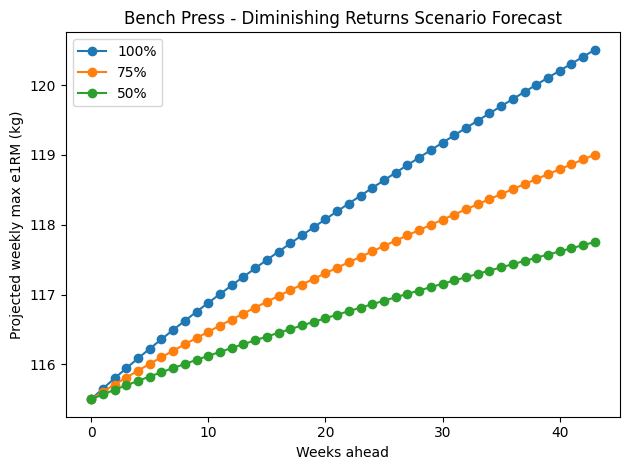

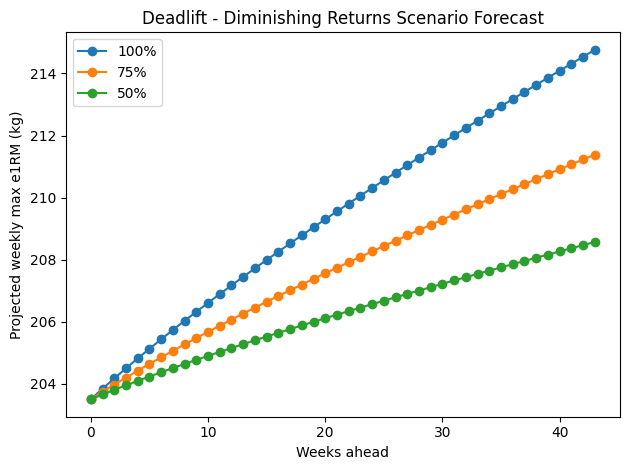

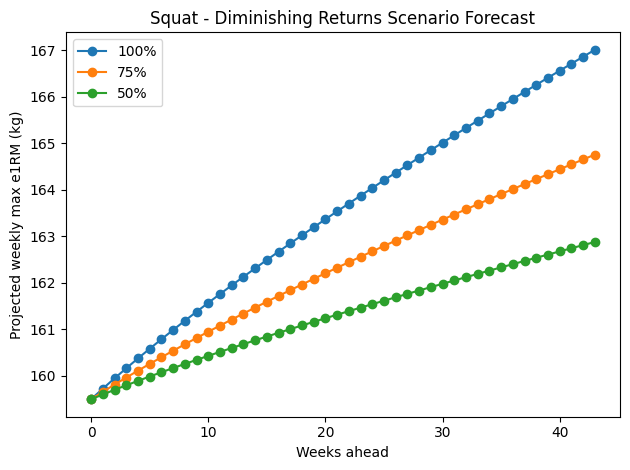

In [26]:
# Plot scenario curves (one lift per chart)

for exercise in projections_df["exercise"].unique():
    sub = projections_df[projections_df["exercise"] == exercise] # filter the projections for the current exercise
    
    plt.figure() # create a new figure for each exercise
    for scenario in sub["scenario"].unique(): # loop through each scenario for the current exercise
        scenario_sub = sub[sub["scenario"] == scenario] # filter the data for the current scenario
        plt.plot(scenario_sub["week_idx"], scenario_sub["e1rm"], marker="o", label=scenario) # plot the projected e1RM over time for the current scenario
    
    plt.title(f"{exercise} - Diminishing Returns Scenario Forecast")        
    plt.xlabel("Weeks ahead")
    plt.ylabel("Projected weekly max e1RM (kg)")    
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Adding Uncertainty bands 

These curves above are deterministic. TO add realsim to the outcomes we need to add uncertainty

To add uncertainty we will approach it in 3 ways;

* Estimate a sigma per lift from historical residuals
* Add noise each week
* Run Monte Carlo to get 80%/95% bands

In [27]:
# Inserting uncertainty bands (using the same sigma from the historical residuals)

import numpy as np

# Estimated sigma (weekly noise) from actual weekly data
weekly_clean = weekly.copy()
weekly_clean["week_start"] = pd.to_datetime(weekly_clean["week_start"])
weekly_clean["exercise"] = weekly_clean["exercise"].astype(str).str.strip() # ensure exercise names are lowercase for consistency

# Estimate volatity (sigma) from the week-to-week differences

diff_sigma = (
    weekly_clean.groupby("exercise")["e1rm"]
    .diff() # calculate week-to-week differences in e1RM for each exercise
    .groupby(weekly_clean["exercise"]) # group by exercise to calculate the standard deviation of differences for each lift
    .std() # calculate the standard deviation of differences for each exercise
    .fillna(1.0) # fill any NaN values with a default sigma of 1.0 kg (in case of insufficient data to calculate sigma for an exercise)
)

diff_sigma

exercise
Bench Press    1.0
Deadlift       1.0
Squat          1.0
Name: e1rm, dtype: float64

## Phase 5B: Monte Carlo Uncertainty Bands

In [28]:
print("Have weeks?", "weeks" in globals()) # check if the variable "weeks" is defined in the global scope and print the result
print("Have projections_df?", "projections_df" in globals()) # check if the variable "projections_df" is defined in the global scope and print the result
print("Have diff_sigma?", "diff_sigma" in globals()) # check if the variable "diff_sigma" is defined in the global scope and print the result
print("Have baseline_gains?", "baseline_gains" in globals()) # check if the variable "baseline_gains" is defined in the global scope and print the result



Have weeks? True
Have projections_df? True
Have diff_sigma? True
Have baseline_gains? True


In [29]:
diff_sigma

exercise
Bench Press    1.0
Deadlift       1.0
Squat          1.0
Name: e1rm, dtype: float64

In [30]:
# Monte Carlo Simulation Core

def simulate_paths(
    e0, # initial e1RM (starting point for the forecast)
    delta0, # initial weekly gain (kg)
    weeks_ahead, # number of weeks to simulate
    adherence_mult, # multiplier for adherence (1.0 = 100% adherence, 0.75 = 75% adherence, etc.)
    sigma, # standard deviation of weekly noise (kg)
    k=12, # diminishing returns parameter
    n_sims=2000, # number of simulation paths to generate
    seed=42 # random seed for reproducibility
):
    rng = np.random.default_rng(seed) # create a random number generator with the specified seed for reproducibility
    t = np.arange(weeks_ahead) # create an array of week indices for the forecast horizon
    
    # Expected gains with diminishing returns
    expected_gain = (delta0 / np.log1p(t + k)) * adherence_mult # calculate the expected weekly gains with diminishing returns and adherence multiplier
    
    # Random weekly noise
    noise = rng.normal(loc=0, scale=sigma, size=(n_sims, weeks_ahead)) # generate random noise for each simulation path and week based on the specified sigma
    
    # Build Paths
    increments = expected_gain + noise # calculate the weekly increments by adding the expected gain and random noise
    paths = np.cumsum(increments, axis=1) + e0 # calculate the cumulative sum of increments to get the projected e1RM for each week, starting from the initial e1RM (e0)
    
    # Anchor week 0 to the initial e1RM
    paths[:, 0] = e0
    
    return paths

In [31]:
# generate forecast bands

bands = []

for exercise, e0 in last_obs.items():
    sigma = float(diff_sigma.get(exercise, 1.0)) # get the sigma for the current exercise, default to 1.0 if not found
    
    for scenario, mult in scenarios.items():
        paths = simulate_paths(
            e0 = float(e0), # ensure e0 is a float for calculations
            delta0 = baseline_gains[exercise], # get the baseline weekly gain for the current
            weeks_ahead = len(weeks), # use the length of the weeks array to determine the forecast horizon
            adherence_mult = mult, # use the scenario multiplier for adherence
            sigma = max(sigma, 1.0), # ensure sigma is at least 1.0 kg to avoid unrealistically narrow bands
            n_sims=2000 # number of simulation paths to generate
        )
        
        p5, p10, p50, p90, p95 = np.percentile(paths, [5, 10, 50, 90, 95], axis=0) # calculate the 5th, 10th, 50th (median), 90th, and 95th percentiles of the simulated paths for each week
        
        bands.append(
            pd.DataFrame({
                "week_idx": weeks,
                "exercise": exercise,
                "scenario": scenario,
                "p5": p5,
                "p10": p10,
                "p50": p50,
                "p90": p90,
                "p95": p95
            })
        ) # Append the calculated percentiles for the current exercise and scenario to the bands list as a DataFrame
        
bands_df = pd.concat(bands, ignore_index=True) # Concatenate all the bands into a single DataFrame
bands_df.head()

,week_idx,exercise,scenario,p5,p10,p50,p90,p95
0,0,Bench Press,100%,115.500000,115.500000,115.500000,115.500000,115.500000
1,1,Bench Press,100%,113.527177,114.029785,115.861688,117.680080,118.166273
2,2,Bench Press,100%,113.188949,113.776662,115.996926,118.283976,118.905951
3,3,Bench Press,100%,112.770363,113.493839,116.113449,118.780148,119.499607
4,4,Bench Press,100%,112.588890,113.346650,116.231061,119.201872,119.962684


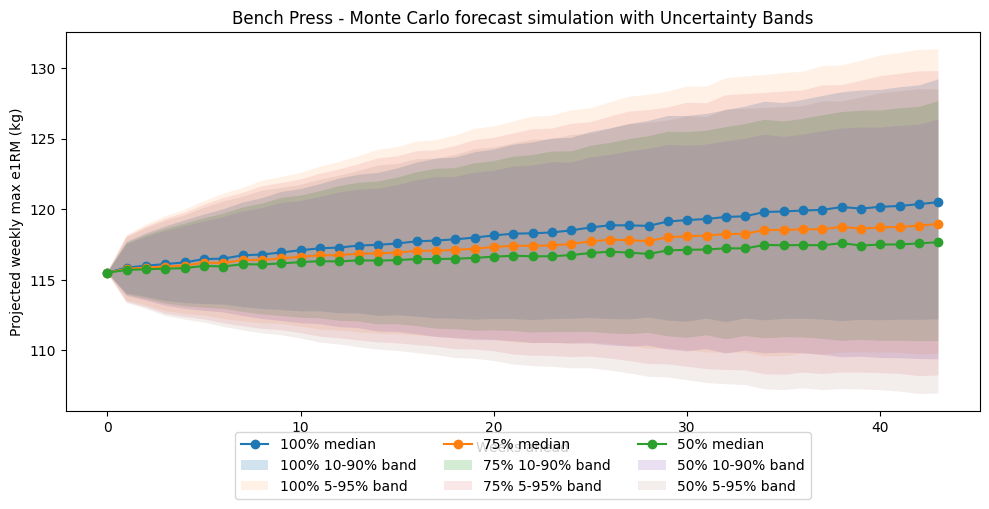

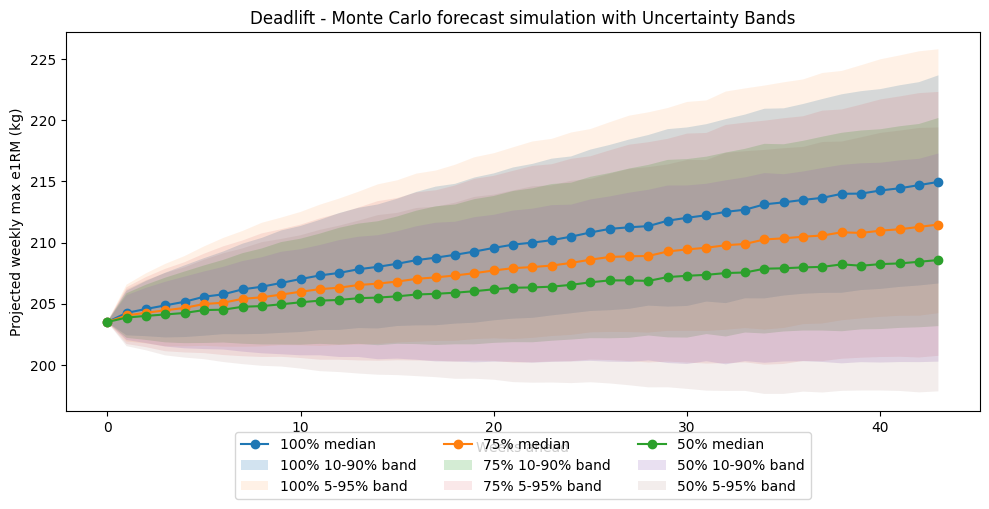

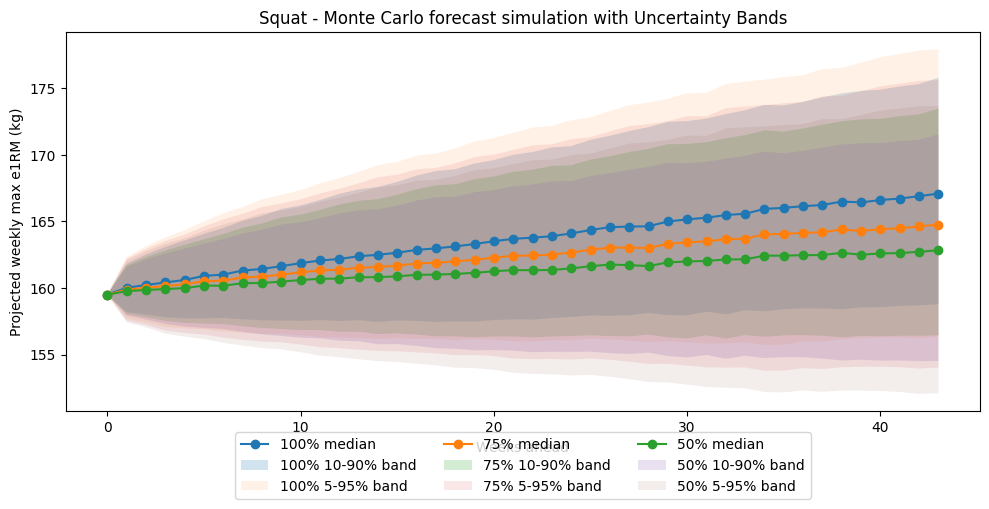

In [32]:
# Plot uncertainty bands

for exercise in bands_df["exercise"].unique():
    plt.figure(figsize=(10, 6))  # Increased figure size for better spacing
    
    for scenario in ["100%", "75%", "50%"]:
        b = bands_df[(bands_df["exercise"] == exercise) & 
                     (bands_df["scenario"] == scenario)
        ].sort_values("week_idx")
        
        plt.plot(b["week_idx"], b["p50"], marker="o", label=f"{scenario} median")
        plt.fill_between(b["week_idx"], b["p10"], b["p90"], alpha=0.2, label=f"{scenario} 10-90% band")
        plt.fill_between(b["week_idx"], b["p5"], b["p95"], alpha=0.1, label=f"{scenario} 5-95% band")
        
    plt.title(f"{exercise} - Monte Carlo forecast simulation with Uncertainty Bands")        
    plt.xlabel("Weeks ahead")
    plt.ylabel("Projected weekly max e1RM (kg)")
    
    # Move legend below the x-axis
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.25),  # Adjust vertical position as needed
        ncol=3,  # Arrange legend items in 3 columns
        frameon=True
    )
    
    # Reserve space for the legend
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave 10% space at bottom
    plt.show()

In [33]:
# Create summary table of projections at 12 months (52 weeks)

# Keep only the key percentiles we want to report
bands_109050 = bands_df[["week_idx", "exercise", "scenario", "p10", "p50", "p90"]].copy()

# Make week_start (date)
# THis ises the last observed week_start for each exercise and adds the week_idx (in weeks) to get the actual date for each week in the forecast horizon

start_week = weekly_clean["week_start"].max() # get the last observed week_start date from the historical data
bands_109050["week_start"] = start_week + pd.to_timedelta(bands_109050["week_idx"] * 7, unit='D') # calculate the week_start date for each week in the forecast horizon by adding the week_idx (converted to days) to the last observed week_start date

bands_109050.sort_values(["exercise", "scenario", "week_idx"]).head(12) # sort the DataFrame by exercise, scenario, and week index for better organization

,week_idx,exercise,scenario,p10,p50,p90,week_start
0,0,Bench Press,100%,115.500000,115.500000,115.500000,2026-02-09
1,1,Bench Press,100%,114.029785,115.861688,117.680080,2026-02-16
2,2,Bench Press,100%,113.776662,115.996926,118.283976,2026-02-23
3,3,Bench Press,100%,113.493839,116.113449,118.780148,2026-03-02
4,4,Bench Press,100%,113.346650,116.231061,119.201872,2026-03-09
5,5,Bench Press,100%,113.283266,116.468025,119.616323,2026-03-16
6,6,Bench Press,100%,113.242582,116.497042,119.993704,2026-03-23
7,7,Bench Press,100%,113.068514,116.735472,120.467899,2026-03-30
8,8,Bench Press,100%,112.931427,116.787564,120.778336,2026-04-06
9,9,Bench Press,100%,112.853011,116.934494,121.223100,2026-04-13


In [34]:
# Lift specific tables at 12 months (52 weeks)


from IPython.display import display, Markdown

for exercise in ["Deadlift", "Bench Press", "Squat"]:
    df = (
        bands_109050[
            (bands_109050["exercise"] == exercise) & 
            (bands_109050["scenario"] == "100%")
        ]
        .sort_values("week_idx")[["week_start", "p10", "p50", "p90"]]
        .head(15)
    )
    display(Markdown(f"### {exercise} - 100% Scenario"))
    display(df)


### Deadlift - 100% Scenario

,week_start,p10,p50,p90
132,2026-02-09,203.500000,203.500000,203.500000
133,2026-02-16,202.414182,204.246085,206.064477
134,2026-02-23,202.345693,204.565958,206.853008
135,2026-03-02,202.243208,204.862817,207.529516
136,2026-03-09,202.272497,205.156908,208.127718
137,2026-03-16,202.382101,205.566860,208.715158
138,2026-03-23,202.511229,205.765689,209.262350
139,2026-03-30,202.504065,206.171022,209.903450
140,2026-04-06,202.531207,206.387344,210.378116
141,2026-04-13,202.614548,206.696032,210.984638


### Bench Press - 100% Scenario

,week_start,p10,p50,p90
0,2026-02-09,115.500000,115.500000,115.500000
1,2026-02-16,114.029785,115.861688,117.680080
2,2026-02-23,113.776662,115.996926,118.283976
3,2026-03-02,113.493839,116.113449,118.780148
4,2026-03-09,113.346650,116.231061,119.201872
5,2026-03-16,113.283266,116.468025,119.616323
6,2026-03-23,113.242582,116.497042,119.993704
7,2026-03-30,113.068514,116.735472,120.467899
8,2026-04-06,112.931427,116.787564,120.778336
9,2026-04-13,112.853011,116.934494,121.223100


### Squat - 100% Scenario

,week_start,p10,p50,p90
264,2026-02-09,159.500000,159.500000,159.500000
265,2026-02-16,158.183544,160.015447,161.833839
266,2026-02-23,158.004274,160.224539,162.511589
267,2026-03-02,157.793587,160.413196,163.079895
268,2026-03-09,157.716989,160.601399,163.572210
269,2026-03-16,157.722800,160.907559,164.055857
270,2026-03-23,157.750041,161.004501,164.501162
271,2026-03-30,157.642735,161.309692,165.042120
272,2026-04-06,157.571339,161.427476,165.418248
273,2026-04-13,157.557626,161.639109,165.927715


In [35]:
from IPython.display import display, Markdown

for exercise in ["Deadlift", "Bench Press", "Squat"]:
    df = (
        bands_109050[
            (bands_109050["exercise"] == exercise) & 
            (bands_109050["scenario"] == "50%")
        ]
        .sort_values("week_idx")[["week_start", "p10", "p50", "p90"]]
        .head(15)
    )
    display(Markdown(f"### {exercise} - 50% Scenario"))
    display(df)

### Deadlift - 50% Scenario

,week_start,p10,p50,p90
220,2026-02-09,203.500000,203.500000,203.500000
221,2026-02-16,202.033629,203.865532,205.683924
222,2026-02-23,201.782352,204.002616,206.289667
223,2026-03-02,201.501333,204.120942,206.787641
224,2026-03-09,201.355909,204.240319,207.211130
225,2026-03-16,201.294254,204.479014,207.627312
226,2026-03-23,201.255268,204.509729,208.006390
227,2026-03-30,201.082870,204.749827,208.482255
228,2026-04-06,200.947425,204.803562,208.794334
229,2026-04-13,200.870626,204.952109,209.240715


### Bench Press - 50% Scenario

,week_start,p10,p50,p90
88,2026-02-09,115.500000,115.500000,115.500000
89,2026-02-16,113.860650,115.692553,117.510945
90,2026-02-23,113.526287,115.746552,118.033602
91,2026-03-02,113.164117,115.783726,118.450425
92,2026-03-09,112.939278,115.823688,118.794499
93,2026-03-16,112.799778,115.984538,119.132836
94,2026-03-23,112.684377,115.938838,119.435499
95,2026-03-30,112.436872,116.103829,119.836257
96,2026-04-06,112.227524,116.083661,120.074432
97,2026-04-13,112.077934,116.159417,120.448023


### Squat - 50% Scenario

,week_start,p10,p50,p90
352,2026-02-09,159.500000,159.500000,159.500000
353,2026-02-16,157.929841,159.761744,161.580137
354,2026-02-23,157.628713,159.848977,162.136028
355,2026-03-02,157.299003,159.918613,162.585312
356,2026-03-09,157.105930,159.990341,162.961151
357,2026-03-16,156.997569,160.182328,163.330626
358,2026-03-23,156.912734,160.167194,163.663856
359,2026-03-30,156.695271,160.362228,164.094656
360,2026-04-06,156.515484,160.371622,164.362393
361,2026-04-13,156.395011,160.476494,164.765100


In [38]:
from IPython.display import display_html
import pandas as pd

# ==========================================
# 1. CONFIGURATION & HELPER FUNCTIONS
# ==========================================

def create_styled_table(df, title, exercise_color):
    """Create a styled DataFrame with color-coded uncertainty bands"""
    
    # Start with base styling
    styled = df.style.set_properties(**{
        'text-align': 'center',
        'padding': '10px 15px',
        'border': '1px solid #ddd',
        'font-size': '13px'
    }).set_table_styles([
        {'selector': 'th', 
         'props': [('background-color', '#2E75B6'), 
                   ('color', 'white'), 
                   ('font-weight', 'bold'),
                   ('text-align', 'center'),
                   ('padding', '12px'),
                   ('border', '1px solid #1a5276')]},
        {'selector': 'td', 
         'props': [('border', '1px solid #ddd')]},
        {'selector': 'tr:hover td', 
         'props': [('background-color', '#f5f5f5')]},
        {'selector': '', 
         'props': [('border-collapse', 'collapse'),
                   ('width', '100%')]}
    ])
    
    # Apply column-specific background colors
    try:
        styled = styled.set_properties(
            subset=['week_start'], 
            **{'background-color': '#f8f9fa', 'font-weight': '600'}
        )
    except KeyError:
        pass
    
    for col in ['p10', 'p50', 'p90']:
        if col in df.columns:
            opacity = '40' if col == 'p50' else '20'
            font_weight = 'bold' if col == 'p50' else 'normal'
            styled = styled.set_properties(
                subset=[col],
                **{
                    'background-color': f'{exercise_color}{opacity}',
                    'color': exercise_color,
                    'font-weight': font_weight
                }
            )
    
    # Build format dict dynamically based on data type
    format_dict = {
        'p10': '{:.1f}',
        'p50': '{:.1f} ★',
        'p90': '{:.1f}'
    }
    
    if 'week_start' in df.columns:
        if pd.api.types.is_numeric_dtype(df['week_start']):
            format_dict['week_start'] = '{:.0f}'
        elif pd.api.types.is_datetime64_any_dtype(df['week_start']):
            format_dict['week_start'] = '{:%Y-%m-%d}'
    
    styled = styled.format(format_dict)
    
    html = f"""
    <div style="display:inline-block; vertical-align:top; margin:10px; min-width:300px;">
        <h3 style="text-align:center; color:#2E75B6; margin-bottom:15px; font-family:Arial;">
            {title}
        </h3>
        {styled.to_html(index=False)}
        <div style="text-align:center; margin-top:10px; font-size:11px; color:#666;">
            <span style="color:{exercise_color}">■</span> p10 (Lower) &nbsp;
            <span style="color:{exercise_color}; font-weight:bold">■</span> p50 (Median) &nbsp;
            <span style="color:{exercise_color}">■</span> p90 (Upper)
        </div>
    </div>
    """
    return html

def display_side_by_side_tables(bands_df, exercises, scenario="100%", n_rows=15):
    """Display multiple exercise forecast tables side-by-side with color coding"""
    
    color_map = {
        "Deadlift": "#C0392B",
        "Bench Press": "#27AE60", 
        "Squat": "#8E44AD"
    }
    
    html_str = '<div style="display:flex; flex-wrap:wrap; justify-content:center; gap:20px;">'
    
    for exercise in exercises:
        df = (
            bands_df[
                (bands_df["exercise"] == exercise) & 
                (bands_df["scenario"] == scenario)
            ]
            .sort_values("week_idx")[["week_start", "p10", "p50", "p90"]]
            .head(n_rows)
            .reset_index(drop=True)
        )
        
        color = color_map.get(exercise, "#2E75B6")
        title = f"{exercise}<br><span style='font-size:12px; font-weight:normal'>{scenario} Scenario</span>"
        html_str += create_styled_table(df, title, color)
    
    html_str += '</div>'
    
    html_str += """
    <div style="text-align:center; margin-top:20px; padding:15px; background-color:#f8f9fa; border-radius:5px; font-family:Arial;">
        <strong>📊 Uncertainty Band Legend:</strong><br>
        <span style="background-color:#C0392B20; color:#C0392B; padding:3px 8px; border-radius:3px; margin:0 5px;">p10</span> 
        Lower 10th percentile
        <span style="background-color:#C0392B40; color:#C0392B; padding:3px 8px; border-radius:3px; margin:0 5px; font-weight:bold;">p50 ★</span> 
        Median
        <span style="background-color:#C0392B20; color:#C0392B; padding:3px 8px; border-radius:3px; margin:0 5px;">p90</span> 
        Upper 90th percentile
    </div>
    """
    
    display_html(html_str, raw=True)

# ==========================================
# 2. EXECUTION
# ==========================================

exercises = ["Deadlift", "Bench Press", "Squat"]
display_side_by_side_tables(bands_109050, exercises, scenario="100%", n_rows=15)

,week_start,p10,p50,p90
0,2026-02-09,203.5,203.5 ★,203.5
1,2026-02-16,202.4,204.2 ★,206.1
2,2026-02-23,202.3,204.6 ★,206.9
3,2026-03-02,202.2,204.9 ★,207.5
4,2026-03-09,202.3,205.2 ★,208.1
5,2026-03-16,202.4,205.6 ★,208.7
6,2026-03-23,202.5,205.8 ★,209.3
7,2026-03-30,202.5,206.2 ★,209.9
8,2026-04-06,202.5,206.4 ★,210.4
9,2026-04-13,202.6,206.7 ★,211.0


In [39]:
import os
import sqlite3
import pandas as pd

# Anchor: last observed week_start
weekly_clean = weekly.copy()
weekly_clean["week_start"] = pd.to_datetime(weekly_clean["week_start"])
start_week = weekly_clean["week_start"].max()

# Prepare save frame
save_df = bands_df.copy()
save_df["week_start"] = start_week + pd.to_timedelta(save_df["week_idx"] * 7, unit="D")
save_df["week_start"] = save_df["week_start"].dt.strftime("%Y-%m-%d")

# DB path
REPO_ROOT = os.path.dirname(os.getcwd())
DB_PATH = os.path.join(REPO_ROOT, "data", "training.sqlite")

conn = sqlite3.connect(DB_PATH)

with conn:
    # Drop and recreate to guarantee schema matches save_df
    conn.execute("DROP TABLE IF EXISTS forecast_bands;")
    conn.execute("""
    CREATE TABLE forecast_bands (
        week_idx INTEGER NOT NULL,
        week_start TEXT NOT NULL,
        exercise TEXT NOT NULL,
        scenario TEXT NOT NULL,
        p5 REAL NOT NULL,
        p10 REAL NOT NULL,
        p50 REAL NOT NULL,
        p90 REAL NOT NULL,
        p95 REAL NOT NULL,
        PRIMARY KEY (week_idx, exercise, scenario)
    );
    """)

save_df.to_sql("forecast_bands", conn, if_exists="append", index=False)

cur = conn.cursor()
cur.execute("SELECT COUNT(*) FROM forecast_bands;")
print("✅ Saved forecast_bands rows:", cur.fetchone()[0])

conn.close()



✅ Saved forecast_bands rows: 396


In [40]:
# pull data back out to verify

REPO_ROOT = os.path.dirname(os.getcwd())
DB_PATH = os.path.join(REPO_ROOT, "data", "training.sqlite")
conn = sqlite3.connect(DB_PATH)

bands_sql = pd.read_sql_query(
    "SELECT week_idx, week_start, exercise, scenario, p5, p10, p50, p90, p95 FROM forecast_bands ORDER BY week_idx, exercise, scenario;",
    conn    
)

conn.close()
bands_sql.head(10)

,week_idx,week_start,exercise,scenario,p5,p10,p50,p90,p95
0,0,2026-02-09,Bench Press,100%,115.5,115.5,115.5,115.5,115.5
1,0,2026-02-09,Bench Press,50%,115.5,115.5,115.5,115.5,115.5
2,0,2026-02-09,Bench Press,75%,115.5,115.5,115.5,115.5,115.5
3,0,2026-02-09,Deadlift,100%,203.5,203.5,203.5,203.5,203.5
4,0,2026-02-09,Deadlift,50%,203.5,203.5,203.5,203.5,203.5
5,0,2026-02-09,Deadlift,75%,203.5,203.5,203.5,203.5,203.5
6,0,2026-02-09,Squat,100%,159.5,159.5,159.5,159.5,159.5
7,0,2026-02-09,Squat,50%,159.5,159.5,159.5,159.5,159.5
8,0,2026-02-09,Squat,75%,159.5,159.5,159.5,159.5,159.5
9,1,2026-02-16,Bench Press,100%,113.5,114.0,115.9,117.7,118.2
